<a href="https://colab.research.google.com/github/TheSamHub/Classification1/blob/main/Classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
import tensorflow as tf 

In [ ]:
train_data_set=pd.read_csv('/content/drive/MyDrive/stumbleupon/train.tsv',sep='\t')

test_data=pd.read_csv('/content/drive/MyDrive/stumbleupon/test.tsv',sep='\t',usecols=['urlid','boilerplate'])

In [ ]:
train_data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [ ]:
test_data.head()

,urlid,boilerplate
0,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc..."
1,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f..."
2,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st..."
3,7640,"{""title"":""Father s Tactics Used by Assad to Cr..."
4,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui..."


In [ ]:
train_data.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

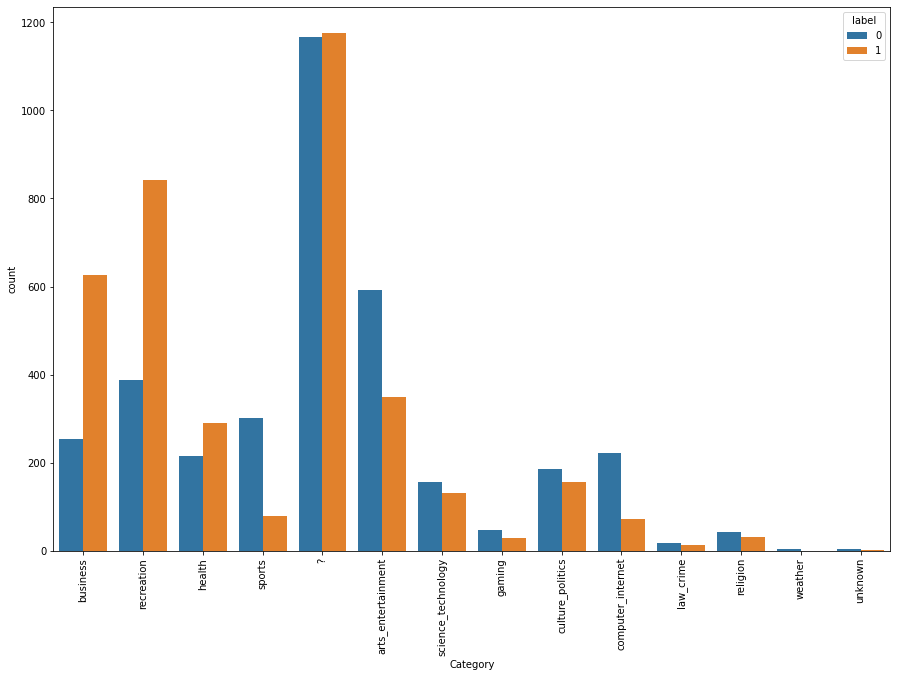

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x=train_data['alchemy_category'],hue=train_data['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

Cleaning data using regex for effective modeling


In [ ]:
train_data['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
train_data['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

train_data['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
train_data['boilerplate']=train_data['boilerplate'].str.lower()



test_data['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
test_data['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

test_data['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
test_data['boilerplate']=test_data['boilerplate'].str.lower()

In [ ]:
pip install transformers

Downloading the tokenizer and the TFAutoModel for fine tuning

In [ ]:
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert=TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BERT uncased Model can handleonly upto 512 tokens at a time , therefore ass all the variabkes for the Transformer Model.
 Then create the X and Y matrix from the train_data set and prepare both the train ans test dataframe.

In [ ]:
length_of_sequence=512

matrix_X=np.zeros((train_data.shape[0],length_of_sequence))
mask_X=np.zeros((train_data.shape[0],length_of_sequence))
y=np.zeros((train_data.shape[0],1))

matrix_X_test=np.zeros((test_data.shape[0],length_of_sequence))
mask_X_test=np.zeros((test_data.shape[0],length_of_sequence))
matrix_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Take the text of some lenghth and then mask it to run the model further.

In [ ]:
for i,sequence in enumerate(train_data['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=length_of_sequence,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    matrix_X[i,:],mask_X[i,:],y[i,0]=tokens['input_ids'],tokens['attention_mask'],train_data.loc[i,'label']
    

for i,sequence in enumerate(test_data['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=length_of_sequence,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    matrix_X_test[i,:],mask_X_test[i,:]=tokens['input_ids'],tokens['attention_mask']
 

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((matrix_X,mask_X,y))

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask},labels

dataset=dataset.map(map_func)
dataset=dataset.shuffle(100000).batch(64).prefetch(1000)

size_dataset=len(list(dataset))


train=dataset.take(round(size_dataset*0.90))
val=dataset.skip(round(size_dataset*0.90))

Prepare test dataset.

In [ ]:
dataset_test=tf.data.Dataset.from_tensor_slices((matrix_X_test,mask_X_test))

def map_func(input_ids,mask):
    return {'input_ids':input_ids,'attention_mask':mask}

dataset_test=dataset_test.map(map_func)
dataset_test=dataset_test.batch(64).prefetch(1000)

Declaring the model and layering

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig
d_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.4, attention_dropout=0.4)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(d_bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(length_of_sequence,), name='input_ids', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(length_of_sequence,), name='attention_mask', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
lay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(embedding_layer)
lay = tf.keras.layers.GlobalMaxPool1D()(lay)
lay = tf.keras.layers.Dense(64, activation='relu')(lay)
lay = tf.keras.layers.Dropout(0.3)(lay)
lay = tf.keras.layers.Dense(32, activation='relu')(lay)
lay = tf.keras.layers.Dropout(0.3)(lay)
lay = tf.keras.layers.Dense(1, activation='sigmoid')(lay)
model = tf.keras.Model(inputs=[input_ids_in, in put_masks_in], outputs = lay)

for layer in model.layers[:3]:
  layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

Model summary and compilation

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 200)     695200      tf_distil_bert_model[0][0]   

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
])

Training 

In [19]:
history=model.fit(train,validation_data=val,epochs=10)

KeyboardInterrupt: ignored

In [ ]:
me_predict=model.predict(dataset_test)
test_data['label']=me_predict

test_data.to_csv('submission.csv',columns=['urlid','label'],index=False)

Final Analytics


In [ ]:
X_in=tf.data.Dataset.from_tensor_slices((matrix_X,mask_X,y))

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask}

X_in=X_in.map(map_func)
X_in=X_in.shuffle(100000).batch(32).prefetch(1000)

y1 = y
y1

In [ ]:
y_predict=model.predict(dataset)
y_predict
y_predict = np.round(y_predict)
y_predict


from sklearn import metrics
print(metrics.classification_report(y1, y_predict))